In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, RocCurveDisplay, auc
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("../dane.csv")
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [3]:
df.info()
df.isna().sum() # liczba pustych komórek

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [4]:
df['Age'] = df['Age'].fillna(df['Age'].mean()) # uzupełnienie wieku wartością średnią
df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0.0) # uzupełnienie wydatków na statku bazową wartością 0.0

In [5]:
df['Group'] = df['PassengerId'].str.split('_', n=1, expand=True)[0] # stworzenie kolumny z grupą, w której znajduje się pasażer
df['MoneySpent'] = np.sum(df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']], axis=1) #stworzenie kolumny z sumą wydatków pasażera na statku

In [6]:
vip_mean = pd.DataFrame(df.groupby(['VIP'])['MoneySpent'].mean()) # średnia wydatków dla VIPów i nie VIPów
vip_level = int(vip_mean['MoneySpent'].iloc[0] + (vip_mean['MoneySpent'].iloc[1] - vip_mean['MoneySpent'].iloc[0])/2) # kwota dla której jest bardziej prawdopodobne, że dany pasażer jest VIPem
df['VIP'] = np.where(df['VIP'].isna(), np.where(df['MoneySpent'] >= vip_level, True, False), df['VIP']) # uzupełnienie brakującego statusu VIP na podstawie vip_level

In [7]:
cryo_mean = pd.DataFrame(df.groupby(['CryoSleep'])['MoneySpent'].mean()) # śradnia wydatków dla osób z kriokabiną i bez
print(cryo_mean) # ustalenie, że osoby które nie wydały nic na statku prawdopodobnie są w kriokabinie
df['CryoSleep'] = np.where(df['CryoSleep'].isna(), np.where(df['CryoSleep'] == 0, True, False), df['CryoSleep']) # uzupełnienie kolumny CryoSleep

            MoneySpent
CryoSleep             
False      2248.299687
True          0.000000


In [8]:
cabin_column = df['Cabin']
df = df.drop(columns=['Cabin'])
df[['CabinDeck', 'CabinNum', 'CabinSide']] = cabin_column.str.split('/', expand=True) # rozdzielenie danych o kabinie na poszczególne elementy

In [9]:
# ustalenie zależności między numerem pokładu, a planetą pochodzenia
print(df.loc[df['CabinDeck']=='A']['HomePlanet'].unique())
print(df.loc[df['CabinDeck']=='B']['HomePlanet'].unique())
print(df.loc[df['CabinDeck']=='C']['HomePlanet'].unique())
print(df.loc[df['CabinDeck']=='D']['HomePlanet'].unique())
print(df.loc[df['CabinDeck']=='E']['HomePlanet'].unique())
print(df.loc[df['CabinDeck']=='F']['HomePlanet'].unique())
print(df.loc[df['CabinDeck']=='G']['HomePlanet'].unique())
print(df.loc[df['CabinDeck']=='T']['HomePlanet'].unique()) 

['Europa' nan]
['Europa' nan]
['Europa' nan]
['Mars' 'Europa' nan]
['Earth' nan 'Mars' 'Europa']
['Earth' 'Mars' nan]
['Earth' nan]
[nan 'Europa']


In [10]:
planet_groups = {'A': 'Europa', 'B': 'Europa', 'C': 'Europa', 'G': 'Earth', 'T': 'Europa'}
set_planet = lambda x: planet_groups[x] if x in planet_groups.keys() else np.nan
df['HomePlanet'] = np.where(df['HomePlanet'].isna(),df['CabinDeck'].apply(set_planet), df['HomePlanet']) # uzupełnienie planety pochodzenia na podstawie numeru pokładu

In [11]:
df['HomePlanet'] = df['HomePlanet'].ffill()
df['CabinDeck'] = df['CabinDeck'].ffill()
df['CabinNum'] = df['CabinNum'].ffill()
df['CabinSide'] = df['CabinSide'].ffill()
df['Destination'] = df['Destination'].ffill()
df.dropna(inplace=True)

In [12]:
df['CabinSide'] = df['CabinSide'].apply(lambda x: 0 if x=='P' else 1)
df['CabinDeck'] = df['CabinDeck'].apply(lambda x: ord(x)-77 if x=='T' else ord(x)-65) 

In [13]:
# name_column = df['Name']
df = df.drop(columns=['Name', 'PassengerId', 'Group', 'Destination'])

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,MoneySpent,CabinDeck,CabinNum,CabinSide
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,0.0,1,0,0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,736.0,5,0,1
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,10383.0,0,0,1
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,5176.0,0,0,1
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,1091.0,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,9276,8536.0,0,98,0
8689,9278_01,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,9278,0.0,6,1499,1
8690,9279_01,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,9279,1873.0,6,1500,1
8691,9280_01,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,9280,4637.0,4,608,1


In [14]:
# df[['FirstName', 'SecondName']] = name_column.str.split(' ', n=1, expand=True)

In [15]:
ohe_data = pd.get_dummies(df, columns=['HomePlanet'])
df = ohe_data

In [16]:
target = df['Transported']
data = df.drop(columns=['Transported'])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [18]:
# fig, ax = plt.subplots(figsize=(16, 16))
# sns.heatmap(df.corr(), annot=True, ax=ax)

((7041, 13), (1652, 13), (7041,), (1652,))

In [19]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

In [20]:
# clf = LogisticRegression()
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

In [21]:
param_grid = {'criterion': ['gini'],
 'max_depth': [15,16,17],
 'max_features': ['sqrt'],
 'min_samples_leaf': [2, 3],
 'min_samples_split': [3, 4],
 'n_estimators': [110, 112, 114]}

In [22]:
# grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

0.8002421307506054
0.8096969696969697
0.7942925089179548
0.801920768307323


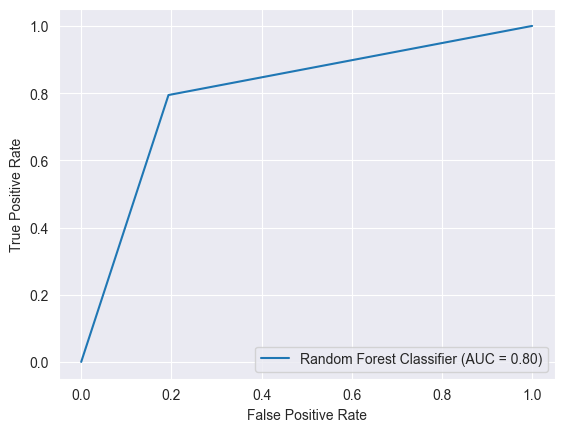

In [23]:
# rfc = RandomForestClassifier(criterion='gini', max_depth=15, max_features='sqrt',min_samples_leaf=3,min_samples_split=4,n_estimators=114)
# rfc.fit(X_train, y_train)
# y_pred = rfc.predict(X_test)

In [58]:
# print(accuracy_score(y_test, y_pred))
# print(precision_score(y_test, y_pred))
# print(recall_score(y_test, y_pred))
# print(f1_score(y_test, y_pred))
# 
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# roc_auc = auc(fpr, tpr)
# display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
# display.plot()
# plt.show()

In [59]:
X_train = torch.tensor(X_train.values)
X_test = torch.tensor(X_test.values) 

In [60]:
class ShallowNeuralNetwork(nn.Module):
    def __init__(self, input_num, hidden_num, output_num):
        super(ShallowNeuralNetwork, self).__init__()
        self.hidden = nn.Linear(input_num, hidden_num) # hidden layer
        self.output = nn.Linear(hidden_num, output_num) # output layer
        self.sigmoid = nn.Sigmoid() # sigmoid activation function
        self.relu = nn.ReLU() # relu activation function
    
    def forward(self, x):
        x = self.relu(self.hidden(x)) 
        out = self.output(x)
        return self.sigmoid(out)

input_num = 15
hidden_num = 15
output_num = 2 # The output should be the same as the number of classes

model = ShallowNeuralNetwork(input_num, hidden_num, output_num)
model.to(device) # send our model to gpu if available else cpu. 
print(model)

ShallowNeuralNetwork(
  (hidden): Linear(in_features=15, out_features=15, bias=True)
  (output): Linear(in_features=15, out_features=2, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)


In [61]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [68]:
if torch.cuda.is_available():
    X_train = Variable(X_train).cuda()
    y_train = Variable(y_train).cuda()
    X_test = Variable(X_test).cuda()
    y_test = Variable(y_test).cuda()

num_epochs = 1000

total_acc, total_loss = [], []

for epoch in range(num_epochs):
    # forward propagation
    with torch.autocast(device_type="cpu", dtype=torch.bfloat16):
        model.train()

        y_pred = model(X_train)
        pred = np.where(y_pred > 0.5, 1, 0)
        loss = criterion(y_pred, y_train)
    
    # back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
      model.eval()
      y_pred_test = model(X_test)

      test_loss = criterion(y_pred_test, y_test)
      total_loss.append(test_loss.item())

      total = 0
      pred = np.where(y_pred_test > 0.5, 1, 0)
      for i in range(len(y_test)):
        if int(y_test[i]) == int(pred[i]):
          total += 1
      
      acc = total / len(y_test)
      total_acc.append(acc)

      print('Epoch [{}/{}], Train Loss: {:.5f}, Test Loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, num_epochs, loss.item(), test_loss.item(), acc))
print('\nTraining Complete')

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and BFloat16